In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pylab as plt
# import vision.sim_tools.connectors.kernel_connectors as kconn
from vision.spike_tools.vis import my_imshow, plot_spikes, \
                                   plot_output_spikes, \
                                   imgs_in_T_from_spike_array, \
                                   build_gif
# from vision.sim_tools.vis import plot_connector_3d
# import vision.sim_tools.kernels.center_surround as csgen
# import vision.sim_tools.kernels.gabor as gabgen

from mpl_toolkits.mplot3d import axes3d, Axes3D

from vision.retina import Retina, dvs_modes, MERGED
from vision.lgn import LGN
from vision.spike_tools.pattern import pattern_generator as pat_gen

# from pyNN import nest as sim
from pyNN import spiNNaker as sim

print(sim.__name__)

pyNN.spiNNaker


In [2]:
def setup_cam_pop(sim, spike_array, img_w, img_h, w2s=1.6):
    print("Setting up camera population...")
    pop_size = img_w*img_h*2
    cell = sim.IF_curr_exp
    params = { 'cm': 0.2,  # nF
               'i_offset': 0.0,
               'tau_m': 10.0,
               'tau_refrac': 2.0,
               'tau_syn_E': 2.,
               'tau_syn_I': 2.,
               'v_reset': -70.0,
               'v_rest': -65.0,
               'v_thresh': -55.4
             }
    dmy_pops = []
    dmy_prjs = []
    
    if sim.__name__ == 'pyNN.spiNNaker':
        cam_pop = sim.Population(pop_size, sim.SpikeSourceArray,
                                 {'spike_times': spike_array},
                                 label='camera')
    else:
        cam_pop = sim.Population(pop_size, cell, params,
                                 label='camera')
        for i in range(pop_size):
            dmy_pops.append(sim.Population(1, sim.SpikeSourceArray, 
                                           {'spike_times': spike_array[i]},
                                           label='pixel (row, col) = (%d, %d)'%\
                                           (i//img_w, i%img_w)))
            conn = [(0, i, w2s, 1)]
            dmy_prjs.append(sim.Projection(dmy_pops[i], cam_pop,
                                           sim.FromListConnector(conn),
                                           target='excitatory'))
    
    
    return cam_pop, dmy_pops, dmy_prjs



def plot_out_spikes(on_spikes, off_spikes, img_w, img_h, 
                    end_t_ms, ftime_ms, thresh, title):
    
    up = None if len(off_spikes) == 0 else 1

    on_imgs = imgs_in_T_from_spike_array(on_spikes, img_w, img_h, 
                                         0, end_t_ms, ftime_ms, 
                                         out_array=True, thresh=thresh, 
                                         up_down=up)
    if len(off_spikes) > 0:
        off_imgs = imgs_in_T_from_spike_array(off_spikes, img_w, img_h, 
                                              0, end_t_ms, ftime_ms, 
                                              out_array=True, thresh=thresh,
                                              up_down=0)
    else:
        off_imgs = [i for i in on_imgs]
    
    num_imgs = len(on_imgs)
    cols = 10
    rows = num_imgs//cols + 1
    figw = 1
    fig = plt.figure(figsize=(figw*cols, figw*rows))
    for i in range(num_imgs):

        off_imgs[i][:,:,1] = on_imgs[i][:,:,1]
        
        ax = plt.subplot(rows, cols, i+1)
        my_imshow(ax, off_imgs[i], cmap=None)
    # plot_spikes(spikes)
    plt.suptitle(title)
    plt.show()
    
    return build_gif(off_imgs, "%s.gif"%title, show_gif=True, title=title, interval=66)

In [3]:
# img_w, img_h = 160, 128
# img_w, img_h = 80, 64
img_w, img_h = 40, 32
step2  = 3
step4  = 6
num_neurons = img_w*img_h*2
fps = 30
frames = 60
thresh = 12
deg = 135
dx = 1.
'''spikes_pol_MERGED_enc_RATE_
   thresh_25_hist_99_
   inh_False___
   64_frames_at_
   30fps_
   32x32_res_spikes
'''
on_time_ms  = int( frames*(1000./fps) )
ftime_ms    = int( 1000./fps )
off_time_ms = 0
start_time  = 10

In [4]:
# spikes_dir = './moving_bar_spikes/deg_%d___dx_%f'%(deg, dx)
# spikes_dir = './breakout_emu_spikes'
# spikes_dir = './breakout_emu_spikes_80'
spikes_dir = './breakout_emu_spikes_40'
spikes = pat_gen.img_spikes_from_to(spikes_dir, num_neurons, 0, 1, 
                                    on_time_ms, off_time_ms,
                                    start_time, delete_before=60)

# print(len(spikes))
# def img_map(nrn_id, img_width, img_height):
#     cols_bits = np.uint8(np.ceil(np.log2(img_width)))
#     cols_mask = int(2**cols_bits - 1)
#     rows_bits = np.uint8(np.ceil(np.log2(img_height)))
#     rows_mask = int(2**rows_bits - 1)

#     col = (nrn_id >> (rows_bits + 1)) & cols_mask
#     row = (nrn_id >> 1) & rows_mask
#     up_dn = nrn_id & 1
    
#     return row, col, up_dn

# imgsU = imgs_in_T_from_spike_array(spikes, img_w, img_h, 
#                                    0, on_time_ms, ftime_ms, 
#                                    out_array=False, thresh=thresh,
#                                    map_func=img_map)
# # imgsD = imgs_in_T_from_spike_array(spikes[1:2*img_w*img_h:2], img_w, img_h, 
# #                                    0, on_time_ms, ftime_ms, 
# #                                    out_array=False, thresh=25)
# num_imgs = len(imgsU)
# cols = 10
# rows = num_imgs//cols + 1
# figw = 1.3
# fig = plt.figure(figsize=(figw*cols, figw*rows))
# for i in range(num_imgs):
# #     out_img = np.zeros((img_h, img_w, 3), dtype=np.uint8)
# #     out_img[:, :, 1] = imgsU[i]
# #     out_img[:, :, 0] = imgsD[i]
#     ax = plt.subplot(rows, cols, i+1)
# #     my_imshow(ax, out_img, cmap=None)
#     my_imshow(ax, imgsU[i], cmap=None)
# # plot_spikes(spikes)
# plt.savefig("test_input.png", dpi=150)
# plt.show()

In [5]:
do_lgn = True
w2s =3.
sim.setup(timestep=1., max_delay=140., min_delay=1.)
# if sim.__name__ == 'pyNN.spiNNaker':
#     sim.set_number_of_neurons_per_core("IF_curr_exp", 50)

cam, dmy_ssa_cam, dmy_prj_cam = setup_cam_pop(sim, spikes, 
                                              img_w, img_h, w2s=w2s)
print(cam.size)
cam.record()
cfg = {'record': {'voltages': False, 
                  'spikes': True,
                 },
#        'w2s': w2s,
       'gabor': False,
       'row_bits': 5,
      }
mode = dvs_modes[MERGED]
retina = Retina(sim, cam, img_w, img_h, mode, cfg=cfg)
if do_lgn:
    lgn = LGN(sim, retina, cfg=cfg)
run_time = on_time_ms

print("Start run for %s ms"%run_time)
sim.run(run_time)

cam_spks = {}
cam_spks['on'] = retina.cam['on'].getSpikes(compatible_output=True)
cam_spks['off'] = retina.cam['off'].getSpikes(compatible_output=True)
inter_cam_spks = {}
inter_cam_spks['on'] = retina.pops['on']['cam_inter'].getSpikes(compatible_output=True)
inter_cam_spks['off'] = retina.pops['off']['cam_inter'].getSpikes(compatible_output=True)


print("Trying to get output spikes")
out_spks = {}
print("\tFor Retina")
for k in retina.pops.keys():
    out_spks[k] = {}
    for p in retina.pops[k].keys():
        out_spks[k][p] = {}
        if isinstance(retina.pops[k][p], dict):
            for t in retina.pops[k][p].keys():
                
                key = "%s__%s__%s"%(k, p, t)
                try:
                    out_spks[k][p][t] = retina.pops[k][p][t].getSpikes(\
                                                    compatible_output=True)
                except:
                    print("no spikes for retina - population %s"%(key))

if do_lgn:
    lgn_spks = {}
    print("\tFor LGN")
    
    for c in lgn.pops.keys():
        lgn_spks[c] = {}
        for k in lgn.pops[c].keys():
            print("\t\t%s %s"%(c,k))
            try:
                lgn_spks[c][k] = lgn.pops[c][k]['output'].getSpikes(\
                                                            compatible_output=True)
            except:
                print("no spikes for lgn - population %s"%(k))

sim.end()

print("-------------------------------------------------------------------")
print("\t\tDone simulation!!!")
print("-------------------------------------------------------------------")

Setting up camera population...
2560
Building Retina (40 x 32)
	Building kernels...
		done!
	Building connectors...
		done!
	Building populations...
		done!
	Building projections...
		done!
Building LGN...
	Building kernels...
		done!
	Building connectors...
		done!
	Building populations...
		done!
	Building projections...
		done!

Generating a virtual machine
|0                           50%                         100%|
Allocating virtual identifiers
|0                           50%                         100%|
Partitioning graph vertices
|0                           50%                         100%|
Partitioning graph edges
|0                           50%                         100%|
Allocating virtual identifiers
|0                           50%                         100%|
Generating partitioner report
|0                           50%                         100%|
Filtering edges
|0                           50%                         100%|
Placing graph vertices
|0                           50%                         100%|
Generating placement report
|0                           50%                         100%|
Generating placement by core report
|0                           50%                         100%|
Generating SDRAM usage report
|0                           50%                         100%|



Start run for 2000 ms
Trying to get output spikes


Getting spikes for Retina: bipolar_on_dir: right2left
|0                           50%                         100%|
Getting spikes for Retina: inter_on_dir: right2left
|0                           50%                         100%|
Getting spikes for Retina: ganglion_on_dir: right2left
|0                           50%                         100%|
Getting spikes for Retina: bipolar_on_dir: tr2bl
|0                           50%                         100%|
Getting spikes for Retina: inter_on_dir: tr2bl
|0                           50%                         100%|
Getting spikes for Retina: ganglion_on_dir: tr2bl
|0                           50%                         100%|
Getting spikes for Retina: bipolar_on_dir: tl2br
|0                           50%                         100%|
Getting spikes for Retina: inter_on_dir: tl2br
|0                           50%                         100%|
Getting spikes for Retina: ganglion_on_dir: tl2br
|0                           50%          


	For Retina
	For LGN


Getting spikes for LGN output on dir: left2right
|0                           50%                         100%|
Getting spikes for LGN output on dir: tl2br
|0                           50%                         100%|
Getting spikes for LGN output on dir: top2bottom
|0                           50%                         100%|


		on dir: left2right
		on dir: tl2br
		on dir: top2bottom
		on dir: bl2tr


Getting spikes for LGN output on dir: bl2tr
|0                           50%                         100%|
Getting spikes for LGN output on cs2
|0                           50%                         100%|
Getting spikes for LGN output on cs
|0                           50%                         100%|


		on cs2
		on cs
		on cs4


Getting spikes for LGN output on cs4
|0                           50%                         100%|
Getting spikes for LGN output on dir: br2tl
|0                           50%                         100%|
Getting spikes for LGN output on dir: right2left
|0                           50%                         100%|
Getting spikes for LGN output on dir: bottom2top
|0                           50%                         100%|


		on dir: br2tl
		on dir: right2left
		on dir: bottom2top
		on dir: tr2bl


Getting spikes for LGN output on dir: tr2bl
|0                           50%                         100%|
Getting spikes for LGN output off dir: left2right
|0                           50%                         100%|
Getting spikes for LGN output off dir: tl2br
|0                           50%                         100%|


		off dir: left2right
		off dir: tl2br
		off dir: top2bottom


Getting spikes for LGN output off dir: top2bottom
|0                           50%                         100%|
Getting spikes for LGN output off dir: bl2tr
|0                           50%                         100%|
Getting spikes for LGN output off cs2
|0                           50%                         100%|
Getting spikes for LGN output off cs
|0                           50%                         100%|


		off dir: bl2tr
		off cs2
		off cs
		off cs4


Getting spikes for LGN output off cs4
|0                           50%                         100%|
Getting spikes for LGN output off dir: br2tl
|0                           50%                         100%|
Getting spikes for LGN output off dir: right2left
|0                           50%                         100%|
Getting spikes for LGN output off dir: bottom2top
|0                           50%                         100%|


		off dir: br2tl
		off dir: right2left
		off dir: bottom2top
		off dir: tr2bl


Getting spikes for LGN output off dir: tr2bl
|0                           50%                         100%|
Getting provenance data from machine graph
|0                           50%                         100%|
Getting provenance data
|0                           50%                         100%|
Getting Router Provenance
|0                           50%                         100%|
2017-01-25 11:16:15 WARNING: The weights from the synapses for Retina: ganglion_on_dir: left2right:1020:1274 on 2, 3, 14 saturated 4 times. If this causes issues you can increase the spikes_per_second and / or ring_buffer_sigma values located within the .spynnaker.cfg file.
2017-01-25 11:16:15 WARNING: The weights from the synapses for Retina: ganglion_off_cs:1020:1274 on 5, 1, 13 saturated 12 times. If this causes issues you can increase the spikes_per_second and / or ring_buffer_sigma values located within the .spynnaker.cfg file.
2017-01-25 11:16:15 WARNING: The weights from the synapses for Retina:


-------------------------------------------------------------------
		Done simulation!!!
-------------------------------------------------------------------


In [6]:
# print(retina.conns['on']['cs4'][0])

# plot RETINA

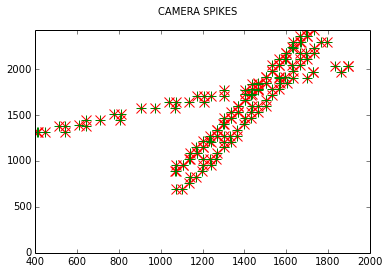

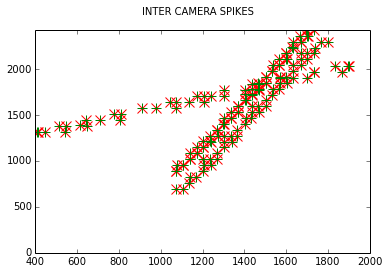

('imgs_in_T, num neurons: ', 1280)
('imgs_in_T, num neurons: ', 1280)


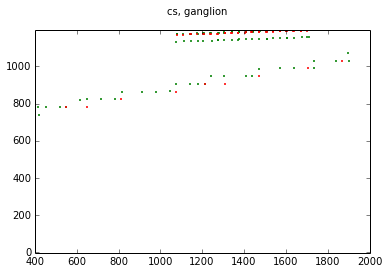

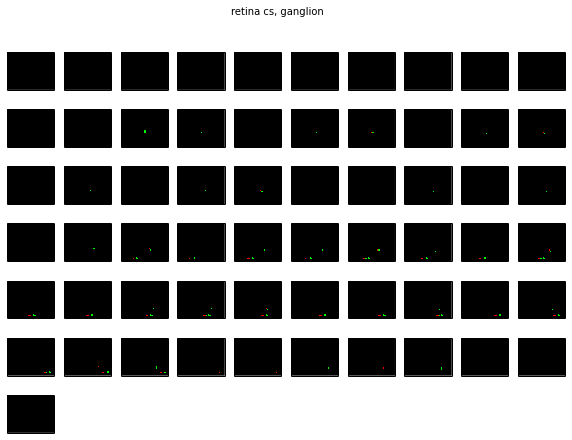

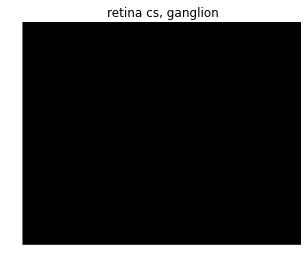

('imgs_in_T, num neurons: ', 130)
('imgs_in_T, num neurons: ', 130)


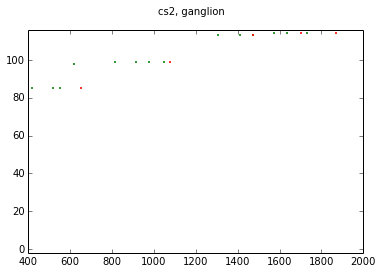

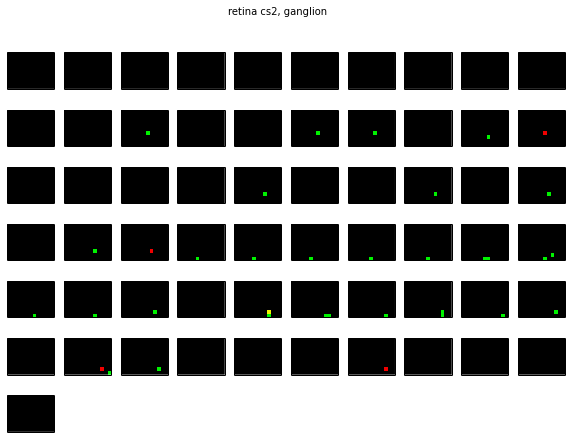

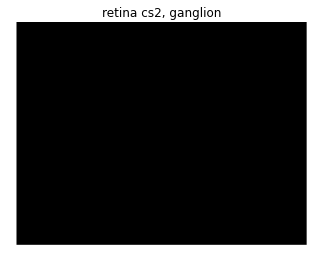

('imgs_in_T, num neurons: ', 30)
('imgs_in_T, num neurons: ', 30)


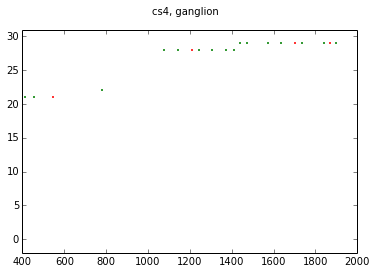

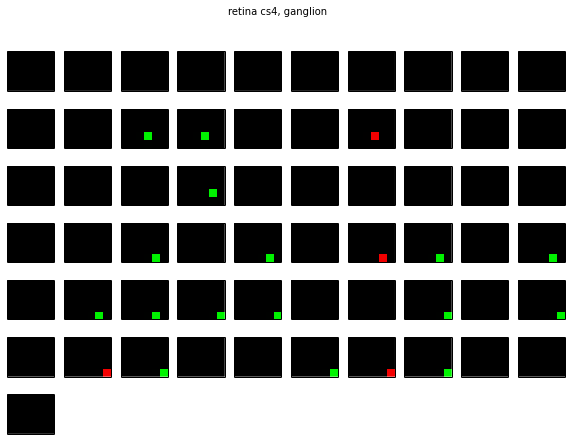

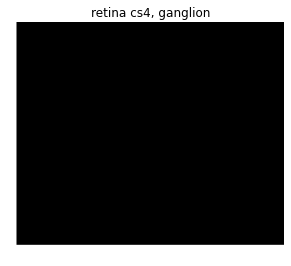

('imgs_in_T, num neurons: ', 2560)


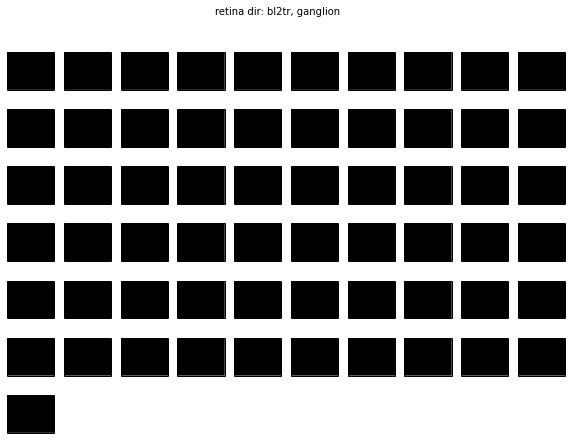

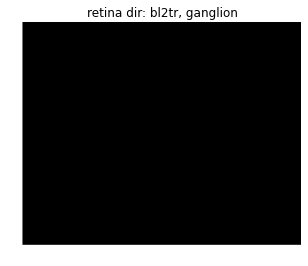

('imgs_in_T, num neurons: ', 2560)


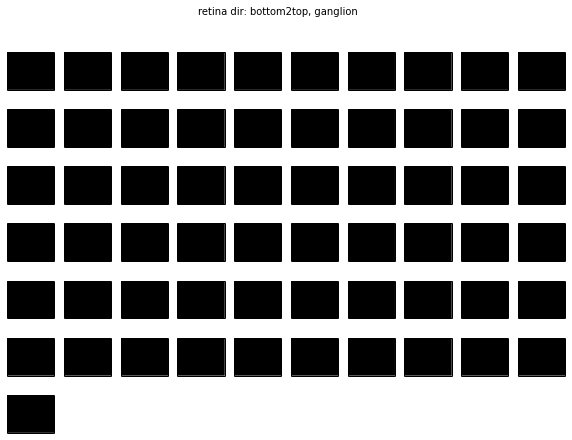

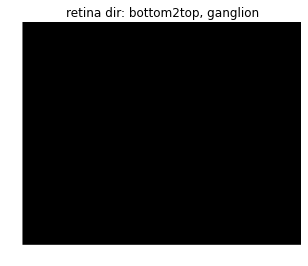

('imgs_in_T, num neurons: ', 2560)


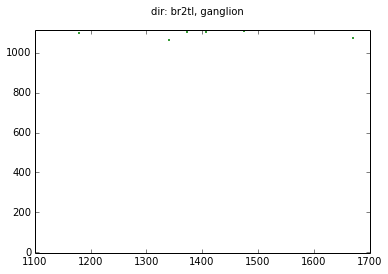

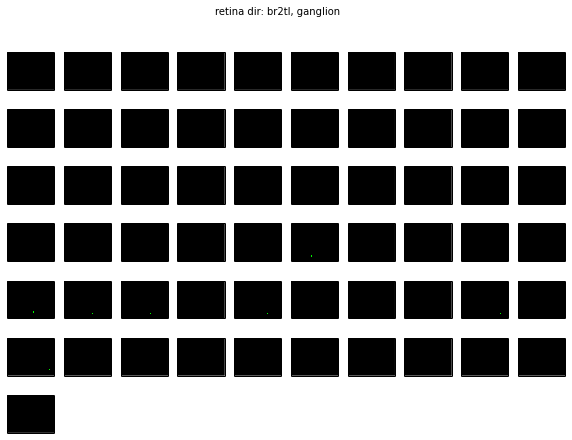

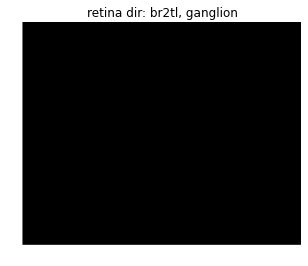

('imgs_in_T, num neurons: ', 1280)
('imgs_in_T, num neurons: ', 1280)


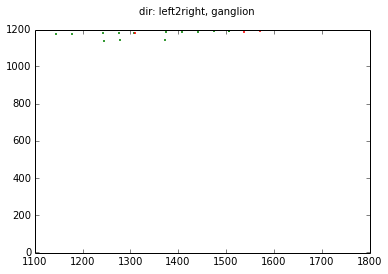

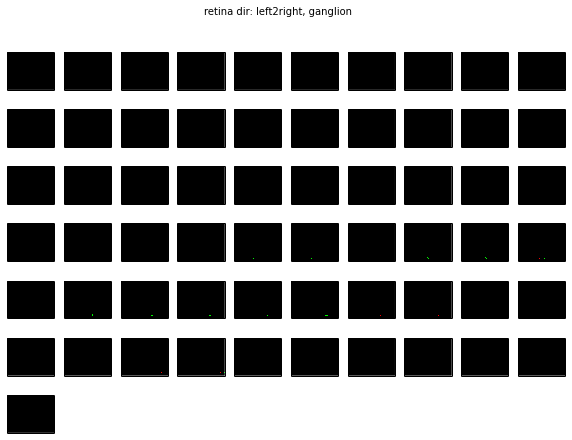

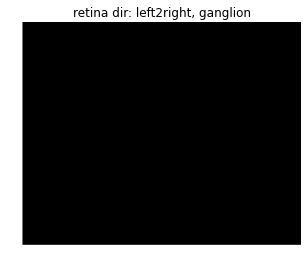

('imgs_in_T, num neurons: ', 2560)


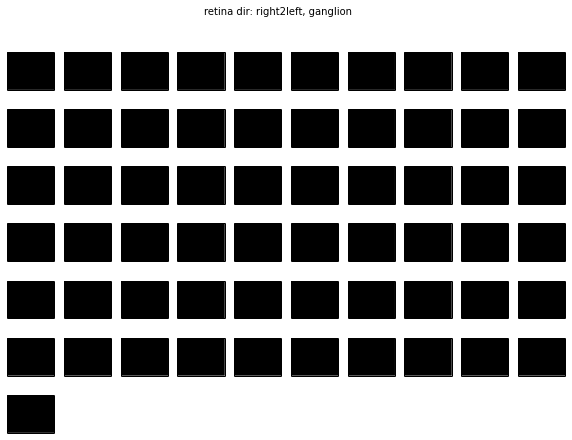

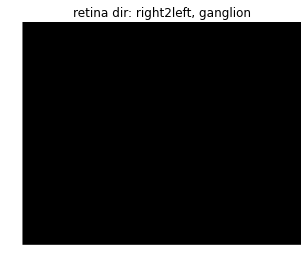

('imgs_in_T, num neurons: ', 2560)


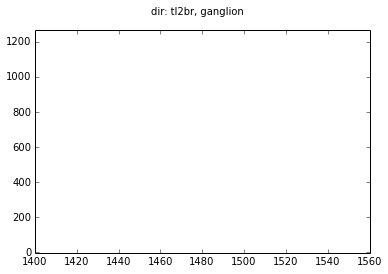

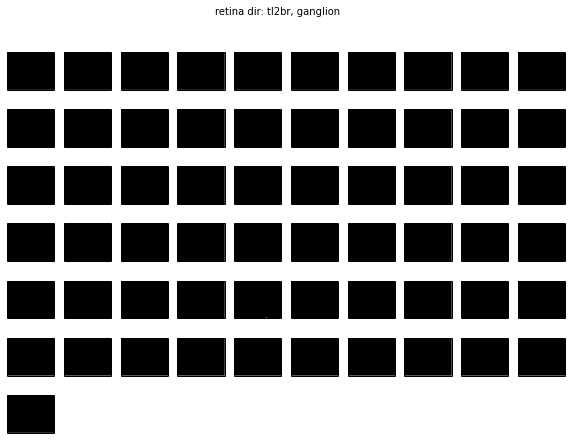

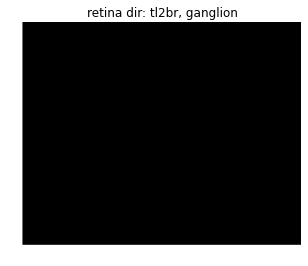

('imgs_in_T, num neurons: ', 2560)


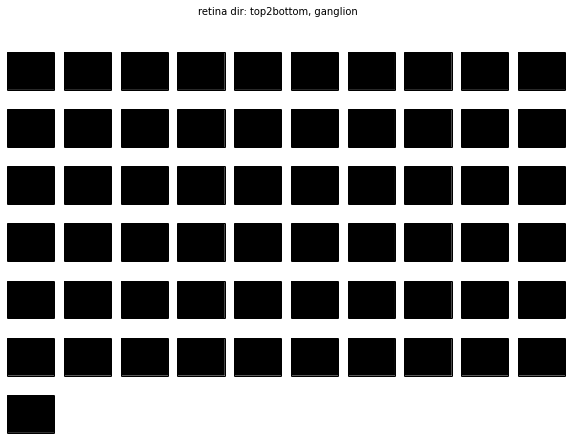

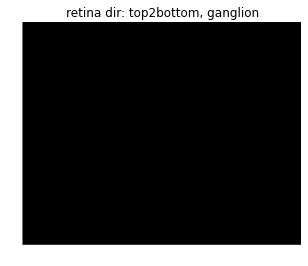

('imgs_in_T, num neurons: ', 2560)


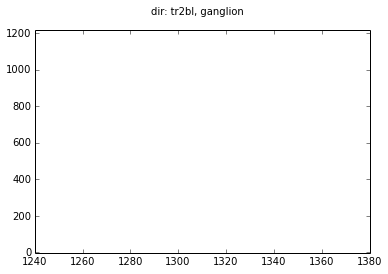

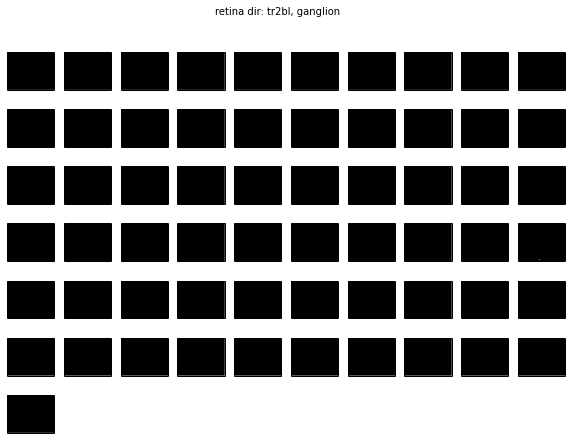

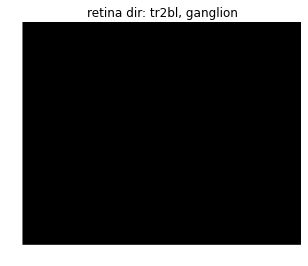

In [7]:

plt.figure()
plot_output_spikes(cam_spks['off'], color='red', markersize=10, 
                   marker='x', markeredgewidth=1, markeredgecolor='red')
plot_output_spikes(cam_spks['on'], color='green', markersize=10, 
                   marker='+', markeredgewidth=1, markeredgecolor='green')

plt.suptitle("CAMERA SPIKES")
plt.show()


plt.figure()

plot_output_spikes(inter_cam_spks['off'], color='red', markersize=10, 
                   marker='x', markeredgewidth=1, markeredgecolor='red')
plot_output_spikes(inter_cam_spks['on'], color='green', markersize=10, 
                   marker='+', markeredgewidth=1, markeredgecolor='green')

plt.suptitle("INTER CAMERA SPIKES")
plt.show()


for p in sorted(out_spks['on'].keys()):
    for t in out_spks['on'][p].keys():

        if t != 'ganglion':
            continue
            
#         if p == 'cs' or p == 'cs2' or p == 'cs4':
#             krn = retina.cs
#             fig = plt.figure(figsize=(1,1))
#             ax = plt.subplot(1,1,1)
#             my_imshow(ax, krn)
# #         else:
# #             krn = retina.gab[p]
#         print("%s, %s"%(p, t))
#         print(len(out_spks['on'][p][t]))
#         print(len(out_spks['off'][p][t]))
        
        if p == 'cs4':
            w = retina.filter_width4
            h = retina.filter_height4
        elif p == 'cs2':
            w = retina.filter_width2
            h = retina.filter_height2
        else:
            w = img_w
            h = img_h
            

        
        fig = plt.figure()#figsize=(16, 18))
        
        plot_output_spikes(out_spks['on'][p][t], color='g')
        plot_output_spikes(out_spks['off'][p][t], color='r')
        plt.suptitle("%s, %s"%(p, t))

        plot_out_spikes(out_spks['on'][p][t], 
                        out_spks['off'][p][t], 
                        w, h, 
                        on_time_ms, ftime_ms, 
                        thresh=thresh, 
                        title="retina %s, %s"%(p, t))
        
        
        
        plt.show()

# plot LGN

('imgs_in_T, num neurons: ', 1280)
('imgs_in_T, num neurons: ', 1280)


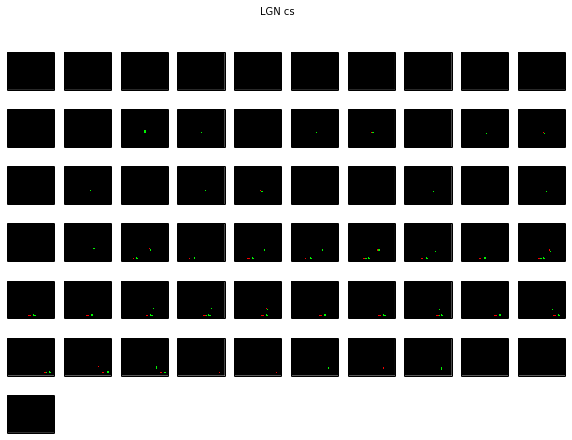

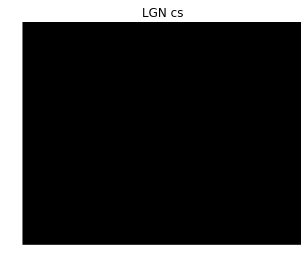

('imgs_in_T, num neurons: ', 130)
('imgs_in_T, num neurons: ', 130)


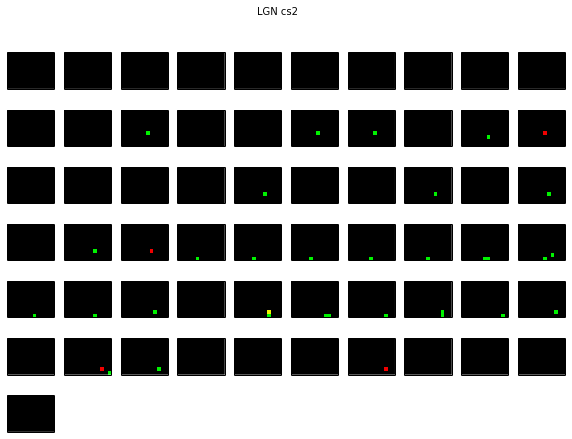

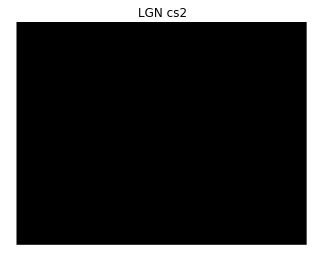

('imgs_in_T, num neurons: ', 30)
('imgs_in_T, num neurons: ', 30)


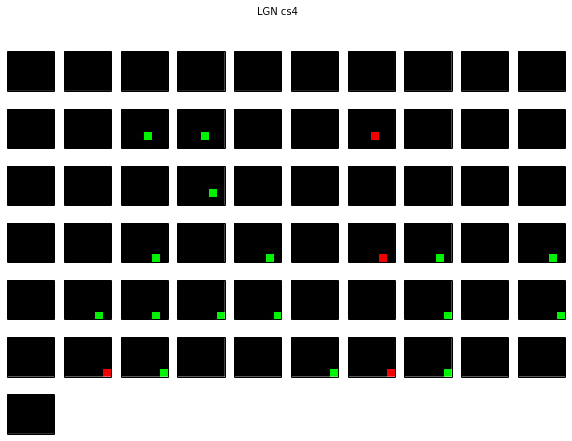

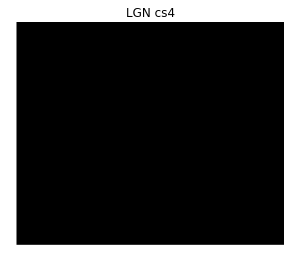

('imgs_in_T, num neurons: ', 2560)


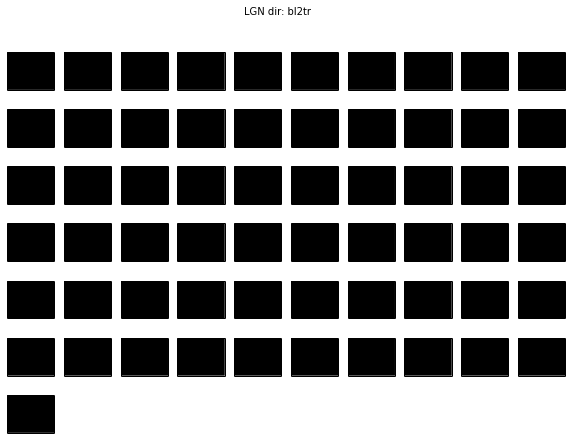

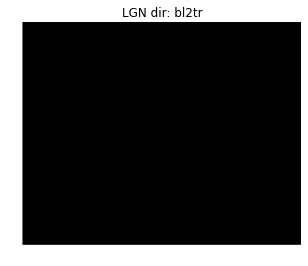

('imgs_in_T, num neurons: ', 2560)


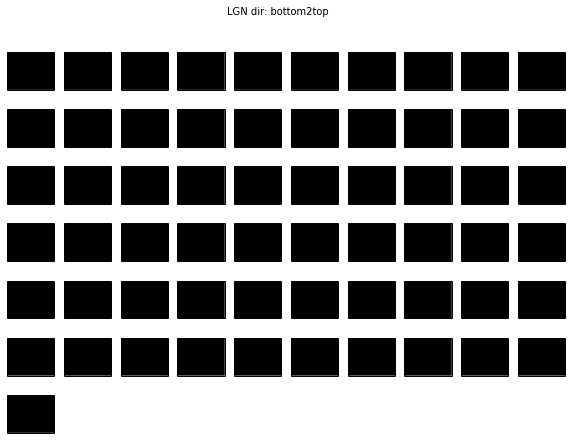

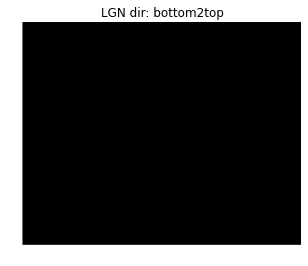

('imgs_in_T, num neurons: ', 2560)


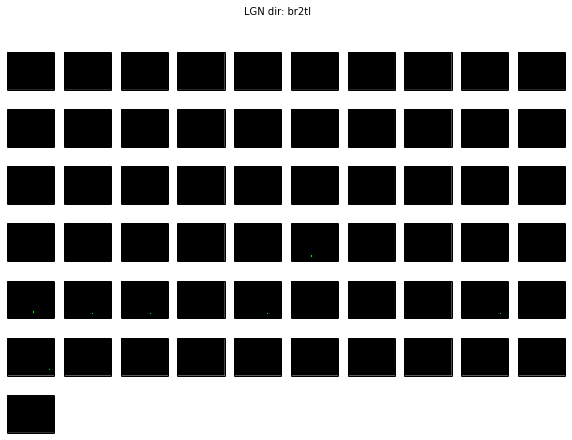

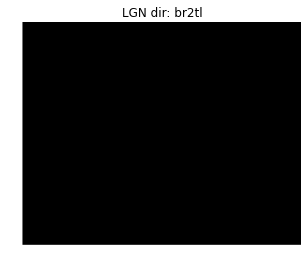

('imgs_in_T, num neurons: ', 1280)
('imgs_in_T, num neurons: ', 1280)


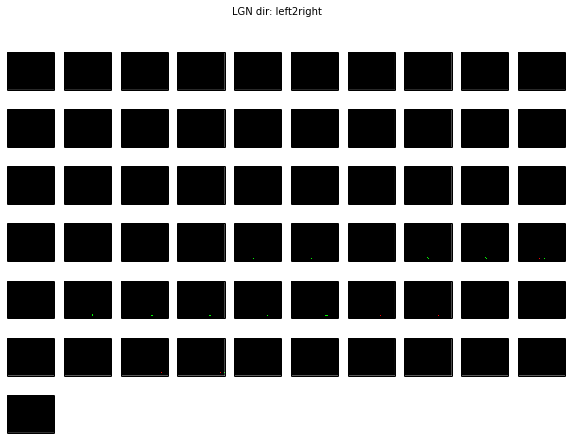

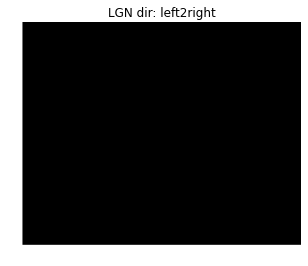

('imgs_in_T, num neurons: ', 2560)


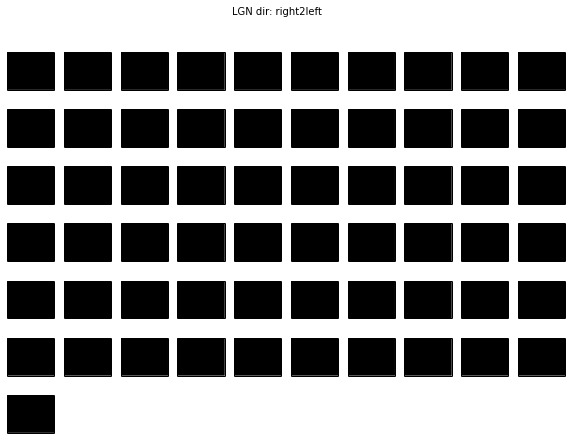

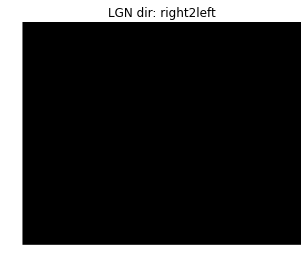

('imgs_in_T, num neurons: ', 2560)


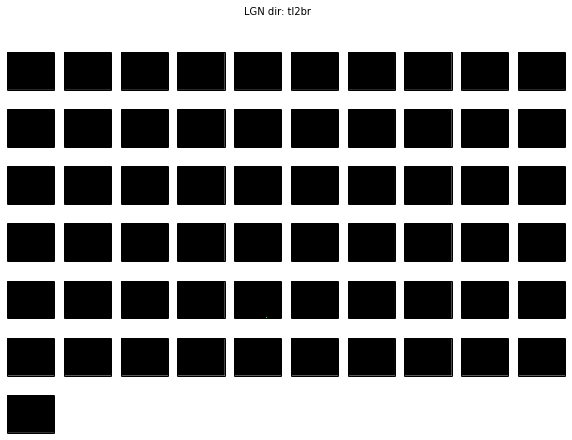

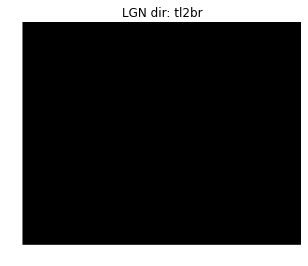

('imgs_in_T, num neurons: ', 2560)


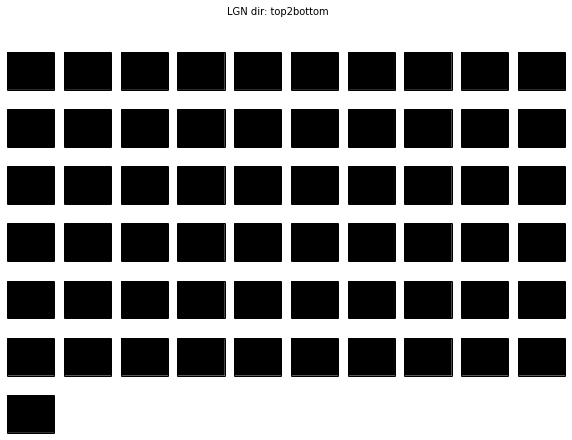

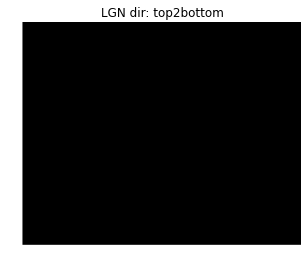

('imgs_in_T, num neurons: ', 2560)


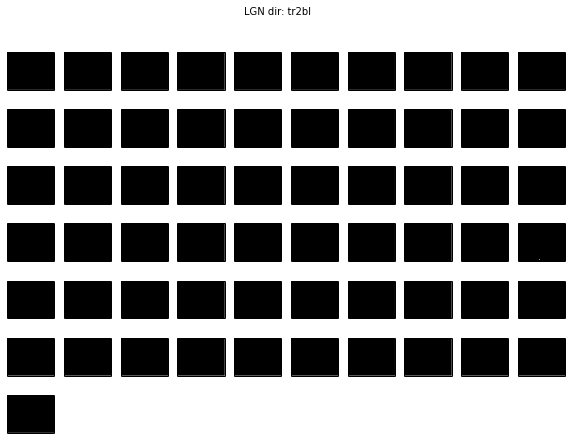

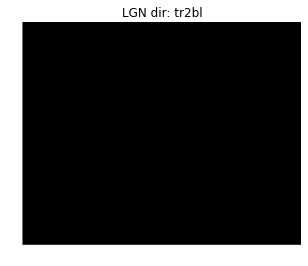

In [14]:
if do_lgn:
    for k in sorted(lgn_spks['on'].keys()):

        if k == 'cs4':
            w = retina.filter_width4
            h = retina.filter_height4
        elif k == 'cs2':
            w = retina.filter_width2
            h = retina.filter_height2
        else:
            w = img_w
            h = img_h

        plot_out_spikes(lgn_spks['on'][k],
                        lgn_spks['off'][k],
                        w, h, 
                        on_time_ms, ftime_ms, 
                        thresh=thresh, 
                        title="LGN %s"%(k))
    #     plt.show()